# Using a Convolutional Neural Net in Histopathologic Cancer Detection #

### Caleb Stillman ###

Link to GitHub repo: https://github.com/cstillma/histopathologic-cancer-detection-CNN

## Description of the Problem and the Data ##

The problem presented by this competition is to create a machine learning algorithm that will be able to accurately predict the presence of cancer cells in pathology images. The data, a nearly 8GB modified version of the PatchCamelyon (PCam) dataset, consists of a "train" folder with 220,025 images, a "test" folder with 57,458 images, and a CSV file called "train_labels.csv," which contains the ground truth for the images in the training folder - two columns consisting of image ID and a binary classification label of 0 or 1 to identify whether that image contains pixels of cancer cells. The data split for the set is therefore roughly 79.3% training and 20.7% testing. Specifically, the problem calls for identifying the presence of pixels containing tumor cells only within the center 32x32px region of each test image - this despite the fact that the images are 96x96px. For each ID in the test set of images, the model must predict the probability that said region contains at least one pixel of cancerous tissue, and the model is to be evaluated on its success on Area Under the Receiver Operating Characteristic Curve, or AUC-ROC. This metric is specifically helpful with binary classification models, as it essentially plots the true positive rate versus the false positive rate, showing how well a model is distinguishing between two classes. Values for this metric are in the range of 0.0 to 1.0, with a score of 1 indicating perfect prediction from the model, while scores closer to 0.5 indicate that the model is guessing randomly. More description of the size, dimension, and structure of the dataset will be included in the below section on data exploration. 

## Data Exploration and Preprocessing ##

The Pandas and NumPy libraries will be used for manipulating the data, matplotlib for plotting visualizations of the data and analyses, OpenCV for image processing, and OS for accessing the dataset and its paths on the local machine. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


Exploration of the data will begin with the CSV file that contains the ground truth for the images in the training set of data. 

In [2]:
# Load training labels
df_labels = pd.read_csv("train_labels.csv")

# Check file loaded correctly
print("Train labels shape:", df_labels.shape)
print("Sample of labels:\n", df_labels.head())


Train labels shape: (220025, 2)
Sample of labels:
                                          id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


Printing the shape of this file shows the expected number of columns and rows, while printing the head of the file shows that the values in the cells are of the expected values. The next step is confirming that none of the cells are missing values.

In [ ]:
# Check for missing ids and labels
print("Missing labels:", df_labels.isnull().sum())

Missing labels: id       0
label    0
dtype: int64


Now that it has been confirmed that no values are missing from the ground truth file, I'm curious about the split of label values within the training set. Verifying the label distribution in the training dataset will help inform me whether the dataset is imbalanced - if it is, it could bias the model or make it useful only to the specific dataset instead of being effective in general, real-world scenarios.  

In [4]:
# Checking label distribution
print("Label distribution: \n", df_labels["label"].value_counts())

Label distribution: 
 label
0    130908
1     89117
Name: count, dtype: int64


The split in training labels is roughly 60/40 in favor of negative results. This is an acceptable distribution and shouldn't over-bias the model. I'm satisfied with my exploration of the ground truth file, so it's time to pivot to exploring the actual image data. To do this, relative paths to the images in the dataset will be set and confirmed against the operating system paths. First, it should be confirmed that no actual images are missing from the training folder. We expect 220,025 images to reside in that folder. Then, it should be confirmed that all of these files can be loaded correctly and that no files were corrupted when downloading the dataset. Some of this code has been commented out due to long runtimes, but the results are also included in comments. 

In [5]:
# Set relative paths to dataset
base_dir = r"c:\Users\Cstil\Documents\GitHub\histopathologic-cancer-detection"
train_images_dir = f"{base_dir}/train"
test_images_dir = f"{base_dir}/test"
labels_file = f"{base_dir}/train_labels.csv"

# # Confirm all image files exist
# missing_files = [img_id for img_id in df_labels["id"] if not os.path.exists(f"{train_images_dir}/{img_id}.tif")]
# print(f"Missing image files: {len(missing_files)}")

# Verified no missing image files: ~7.8s to run

In [6]:
# Check for corrupt images
def is_corrupt(image_path):
    img = cv2.imread(image_path)
    return img is None

# corrupt_images = [img_id for img_id in df_labels["id"] if is_corrupt(f"{train_images_dir}/{img_id}.tif")]
# print(f"Corrupt images found: {len(corrupt_images)}")

# Verified no corrupt images: ~107m 28s to run

Now that it has been confirmed that no training images are missing or corrupted, I want to perform some data preprocessing and cleaning prior to creating and training a model. To begin with, I want to do this only on a single image, to make sure the preprocessing and cleaning works prior to attempting to apply this to the whole dataset. In terms of data cleaning, I'm again confirming no missing or corrupted images, and I'm also attempting to standardize the image size to 96x96 pixels. Checking a few at random in the data explorer shows that this seems to be the given image size, but if there are outliers I don't want them to cause issues further down the pipeline. The preprocessing portion involves cropping each image so that only the required center 32x32px patch is being checked for pixels of tumor tissue instead of the entire image. Then, the pixel values in the resulting crop will be normalized for use with the model. Standardization (centering the pixel values around 0 with a standard deviation of 1) was considered but ultimately min-max normalization was chosen for a couple reasons: it scales pixel values from "0 to 255" to "0 to 1", optimizing the model; normalization works better for models trained from scratch than standardization, which works better for pre-trained models; and min-max normalization is simpler and already common to use in image classification. 

Image Min Pixel Value: 0.6941176470588235
Image Max Pixel Value: 1.0
Image Mean Pixel Value: 0.9611123876633987
Image Standard Deviation Pixel Value: 0.02199831703404671


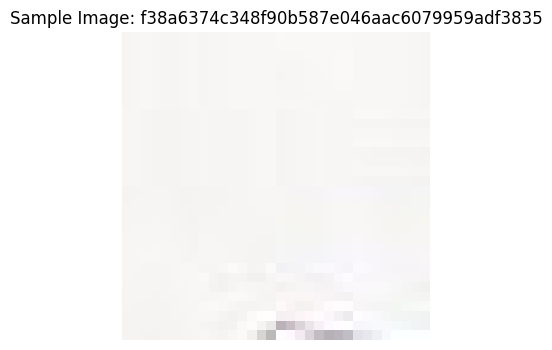

In [23]:
# Loading and preprocessing function for images
def load_and_preprocess_sample(image_path):
    # Loads an image in RGB format, resizes it, and normalizes pixel values
    img = cv2.imread(image_path, cv2.IMREAD_COLOR) # read image in full RGB format
    if img is None: # check if image failed to load
        print(f"Warning: Failed to load {image_path}")
        return None
    img = cv2.resize(img, (96, 96)) # resize for consistency
    # Extract center 32x32px region
    center_crop = img[32:64, 32:64, :] # crop the resized image to the central region
    center_crop = center_crop / 255.0 # normalize pixel values (scale between 0 and 1)
    # Check that normalization occurs correctly
    print(f"Image Min Pixel Value: {np.min(center_crop)}")
    print(f"Image Max Pixel Value: {np.max(center_crop)}")
    print(f"Image Mean Pixel Value: {np.mean(center_crop)}")
    print(f"Image Standard Deviation Pixel Value: {np.std(center_crop)}")
    # Convert image to uint8 for OpenCV compatibility (for visualization purposes only, images will remain normalized for actual modeling purposes)
    img_uint8 = (center_crop * 255).astype(np.uint8)
    return img_uint8

# Load a sample image
sample_image_id = df_labels.iloc[0]['id'] # pull the first image ID from the dataframe
sample_image_path = f"{train_images_dir}/{sample_image_id}.tif" # fetch the corresponding image
sample_image = load_and_preprocess_sample(sample_image_path) # load and preprocess the image

# # Plot a frequency histogram to check distribution of pixel intensities after normalization
# plt.hist(sample_image.ravel(), bins = 50, color = 'blue', alpha = 0.7)
# plt.title("Pixel Value Distribution After Normalization")
# plt.xlabel("Pixel Value")
# plt.ylabel("Frequency")
# plt.show()

# Display the sample image
if sample_image is None:
    print(f"Error: Failed to load{sample_image_path}.")
else:
    plt.figure(figsize=(4, 4)) # set figure size
    plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)) # convert from OpenCV BGR to RGB
    plt.title(f"Sample Image: {sample_image_id}")
    plt.axis("off")
    plt.show()



Print statements and a histogram plot above checked that the normalization occurred correctly: the min pixel value should be closer to 0 while the max pixel value should be closer to 1; the mean should be within the range of 0 to 1, and the standard deviation will indicate how much variation there is in image intensity. The histogram showed values between 0 and 1, indicating that normalization worked (this has been commented out since the histogram and the cropped image can't both be shown at the same time as the code is written, hence the print statements as after normalization but before converting the image back to 255 for checking the crop). The print statements in the function are within the expected values, confirming correct normalization of the image. Additionally, the image was first plotted without cropping and was able to be plotted without issue. The function was then slightly altered to apply the crop, producing the image seen above. This is a correct crop of the center of the specified sample image, which is largely the white space seen above: 

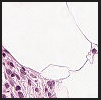

Having confirmed that the cleaning and preprocessing function works on sample images, an adjusted version was created to apply to the entire training set of images, seen below. The processed images are stored in arrays, batch processed, and then converted to NumPy arrays, which are better suited for use with deep learning frameworks. The image data is stored in x_train and the label data is stored in y_train. As one might expect, batch processing 220,025 images takes a while - just over an hour on my local machine. A check was included on the shape of the data in each NumPy array, and produces the expected number and dimensions of the data for both the images and the binary classification labels. 

In [8]:
# Preprocess the training dataset
def load_and_preprocess(image_path):
    # Loads an image, resizes, and normalizes pixel values. 
    img = cv2.imread(image_path, cv2.IMREAD_COLOR) # read image in RGB format
    if img is None: # handle missing images
        print(f"Warning: Failed to load {image_path}")
        return None
    img = cv2.resize(img, (96, 96)) # resize for consistency in image size
    # Extract center 32x32px region
    center_crop = img[32:64, 32:64, :] # crop the resized image to the central region
    center_crop = center_crop / 255.0 # normalize pixel values (scale between 0 and 1)
    return center_crop

# Process all training images
train_image_paths = [f"{train_images_dir}/{img_id}.tif" for img_id in df_labels["id"]]

# Initialize storage
x_train = [] # image data
y_train = [] # label data

# Batch processing loop
for i, img_path in enumerate(train_image_paths):
    img = load_and_preprocess(img_path)
    if img is not None: # ensure valid image
        x_train.append(img)
        y_train.append(df_labels.iloc[i]["label"]) # corresponding label
    if i % 10000 == 0:
        print(f"Processed {i} images")

# Convert lists to NumPy arrays
x_train = np.array(x_train, dtype = np.float32) # convert image data to float32 since pixel values are continuous and range from 0.0 to 1.0
y_train = np.array(y_train, dtype = np.uint8) # convert label data to simpler datatype since values are binary and integers
print("Dataset preprocessing complete!")
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")


Processed 0 images
Processed 10000 images
Processed 20000 images
Processed 30000 images
Processed 40000 images
Processed 50000 images
Processed 60000 images
Processed 70000 images
Processed 80000 images
Processed 90000 images
Processed 100000 images
Processed 110000 images
Processed 120000 images
Processed 130000 images
Processed 140000 images
Processed 150000 images
Processed 160000 images
Processed 170000 images
Processed 180000 images
Processed 190000 images
Processed 200000 images
Processed 210000 images
Processed 220000 images
Dataset preprocessing complete!
x_train shape: (220025, 32, 32, 3), y_train shape: (220025,)


## Model Training and Evaluation ##

The model architecture that was chosen for this project was a convolutional neural network. Transfer learning was also considered because there are some pre-trained models that are built to work with image classification. While these can provide faster training due to pre-learned features and can be a little more computationally efficient, I ultimately went with a CNN because of the customizability to my specific purpose of histopathologic cancer detection and the fact that I have a very large dataset, which CNNs handle somewhat better than transfer learning models. Additionally, the pre-trained models may not have been trained on medical images specifically, so some of their features might not even translate to the purpose of this model. 

Once that choice was made, my choices for implementing a CNN were Keras or PyTorch. This was an easier choice for me - I went with Keras because it's easier to work with for beginners due to the built-in layers for CNNs and more intuitive syntax. I also planned to take advantage of its strong ecosystem of TensorFlow tools. I did run into an issue with installation; TensorFlow is meant to include Keras and my initial import statement was 

`import tensorflow as tf
from tensorflow.keras import layers, models`

but my IDE and terminal were giving me warnings about Keras not being found. I got around this by installing it separately, and have still been able to incorporate the modules I wanted without much issue. 

I chose to define a sequential CNN architecture, matching it to the input shape of the cropped images in the training set. I used binary crossentropy for the loss function because mine is a binary classification problem, and I optimized the model with Adam, which is meant to be a good choice for medical imaging tasks. I added AUC from metrics so I can evaluate my model on the required metric for grading on Moodle and scoring on Kaggle. I decided to use three convolutional layers in the model to extract the relevant tumor features. I incorporated MaxPooling into each layer so I could reduce spatial dimensions while (hopefully) still preserving important details from the images. I set the dropout to 0.5 to prevent overfitting the model, given the 60/40 class imbalance noted above. I used sigmoid activation in the final layer so that the model will output probabilities as required for binary classification. I trained it with 10 epochs and split 10% of the training set into a validation set so I could evaluate the model's success. 

In [9]:
import tensorflow as tf
import keras
from keras import layers, models, metrics

# Define convolutional neural net architecture

model = models.Sequential([
    # Convolutional layers for feature extraction
    layers.Conv2D(32, (3, 3), activation = "relu", input_shape = (32, 32, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation = "relu"),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation = "relu"),
    layers.MaxPooling2D(1, 1),

    # Flatten before fully connected layers
    layers.Flatten(), 
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.5), # to prevent overfitting
    layers.Dense(1, activation = "sigmoid") # Binary classification
])

# Compile model with appropriate loss and optimizer
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy", metrics.AUC()])

print(model.summary())

# Train the model
history = model.fit(x_train, y_train, epochs = 10, batch_size = 32, validation_split = 0.1)

C:\Users\Cstil\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,649 (1.36 MB)

 Trainable params: 355,649 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.7488 - auc: 0.8061 - loss: 0.5241 - val_accuracy: 0.7932 - val_auc: 0.8687 - val_loss: 0.4546
Epoch 2/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.7934 - auc: 0.8566 - loss: 0.4587 - val_accuracy: 0.8049 - val_auc: 0.8761 - val_loss: 0.4356
Epoch 3/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.8040 - auc: 0.8689 - loss: 0.4405 - val_accuracy: 0.7993 - val_auc: 0.8685 - val_loss: 0.4552
Epoch 4/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.8117 - auc: 0.8772 - loss: 0.4272 - val_accuracy: 0.8064 - val_auc: 0.8806 - val_loss: 0.4261
Epoch 5/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - accuracy: 0.8157 - auc: 0.8830 - loss: 0.4180 - val_accuracy: 0.8064 - val_auc: 0.8814 - val_loss: 0.4297
Epoch 6/10
6189/6189 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.8206 - auc: 0.8892 - loss: 0.4079 - val_accuracy: 0.8207 - val_auc: 0.8927 - val_loss: 0.4073
Epoch 7/10
6189/6

The next step is to evaluate the model's performance prior to making predictions on the test set of images; to that end, accuracy, loss, and area under the curve were plotted to visualize how the model did on the training set and on the smaller validation set. 

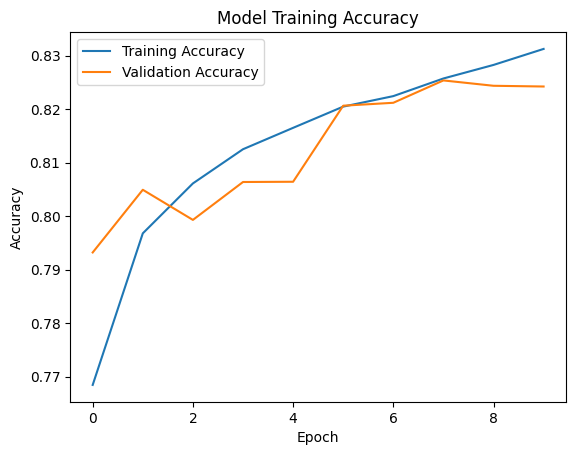

In [10]:
# Plot training history: accuracy
plt.plot(history.history["accuracy"], label = "Training Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.title("Model Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Graphing the accuracy shows that both the training and validation curves are increasing across epochs, which is ideal. In epochs 1-4, it looks like the model might be memorizing the training data instead of generalizing since it drops and has difficulty following the training accuracy, but the model does seem to correct this behavior in later epochs, with epochs 5-7 in particular indicating that the model is performing well on previously unseen data since validation accuracy follows training accuracy so closely there. Overall, this graph suggests that the model might have a slight tendency toward overfitting, but the steady increase in accuracy throughout suggests that underfitting isn't a problem for the model. Overall, I'm pleased with these results. 

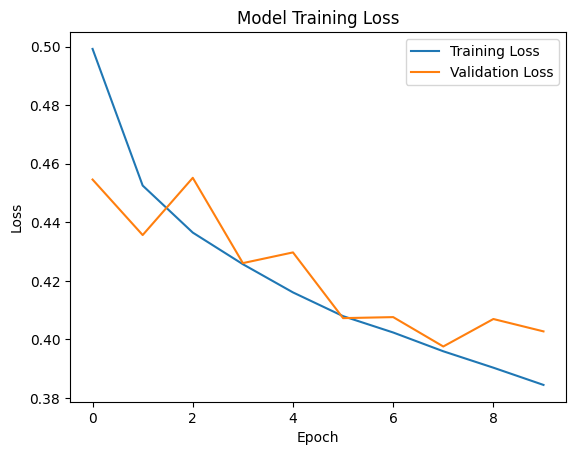

In [11]:
# Plot training history: loss
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.title("Model Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

The loss graph above is also generally showing ideal model behavior, since training and validation loss both fall steadily across epochs. However, some of the jumps in the validation loss seem to reinforce what was seen in the accuracy graph - the model could be overfitting or isn't learning stable patterns. Ideally, I'd have seen training and validation loss stabilizing toward a minimum value, indicating convergence. In broad strokes, the model is mostly performing well, but seems like it could use some tuning. 

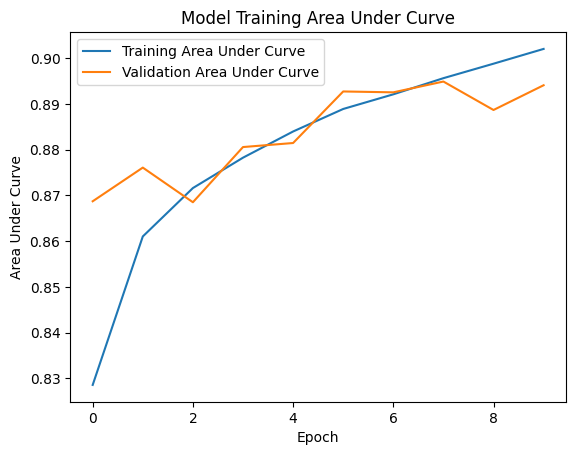

In [13]:
# Plot training history: AUC
plt.plot(history.history["auc"], label = "Training Area Under Curve")
plt.plot(history.history["val_auc"], label = "Validation Area Under Curve")
plt.title("Model Training Area Under Curve")
plt.xlabel("Epoch")
plt.ylabel("Area Under Curve")
plt.legend()
plt.show()

Graphing the area under the curve supports the hypotheses I've been deriving from my analysis of the previous two graphs. In terms of the more general behavior, the graph shows exactly what I want to be seeing - both training and validation AUC steadily increasing (not quite as steady as I'd like from the validation set, but still a general trend up over the course of the plot). What I'm not seeing that I'd hope to see is the convergence of the training and validation AUC at the end of the graph, which would be one of the best indicators of the model's predictive power. That said, I could be being too picky because I'm pretty zoomed in on all of these graphs: ranges for all three metrics are from 0.0 to 1.0, but that's not the range I'm showing on the y-axis on any of these graphs. For instance, if I zoom out on the AUC graph, the model looks extremely stable on both the training and validation sets, and does appear to converge at the end of the epochs:

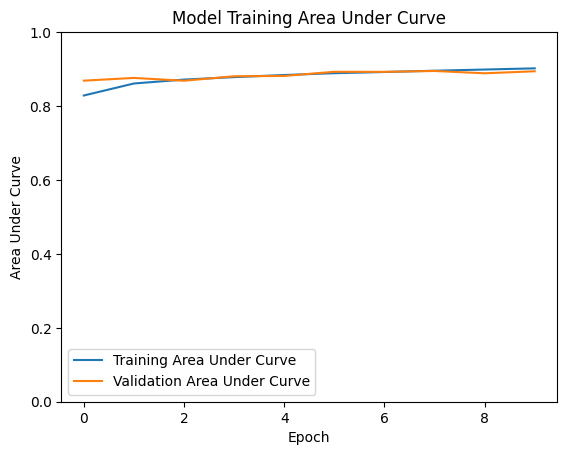

In [24]:
# Plot training history: AUC zoomed out
plt.plot(history.history["auc"], label = "Training Area Under Curve")
plt.plot(history.history["val_auc"], label = "Validation Area Under Curve")
plt.title("Model Training Area Under Curve")
plt.xlabel("Epoch")
plt.ylabel("Area Under Curve")
plt.legend()
plt.ylim(0.0, 1.0) # adjust y-axis range
plt.show()

Also, when I consider the validation metrics and the model's ROC-AUC score:

In [14]:
# Evaluate the model's performance on the validation set to see how well it's performing on data it didn't see during training
val_loss, val_acc, val_auc = model.evaluate(x_train[-len(y_train)//10:], y_train[-len(y_train)//10:])
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")
print(f"Validation AUC: {val_auc}")

688/688 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8240 - auc: 0.8975 - loss: 0.3968
Validation Loss: 0.4027373790740967
Validation Accuracy: 0.8242512345314026
Validation AUC: 0.8940631151199341


In [15]:
# Compute ROC-AUC Score to see how well the model separates positive vs. negative samples
from sklearn.metrics import roc_auc_score

y_val_pred = model.predict(x_train[-len(y_train)//10:]) # probabilities

auc_score = roc_auc_score(y_train[-len(y_train)//10:], y_val_pred)
print(f"ROC-AUC Score: {auc_score}")

688/688 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
ROC-AUC Score: 0.8940751811041908


Validation loss is relatively low at 0.4 - obviously this could be better but it's low enough to suggest that any overfitting in the model is not severe. Validation accuracy at 0.82 is also pretty solid, the model is correctly classifying 82.4% of images. While I could be happier with this, there's a reason accuracy alone isn't often used as the only evaluation metric, especially with imbalanced datasets. As we know, the dataset is only slightly imbalanced, but if the distribution of each label in the training set was 50/50 instead of 60/40, would the accuracy improve? The metric that carries the most weight with me here is the AUC anyway, and that's really good. I've read that when evaluating AUC, above 0.7 is decent, above 0.8 is good, and above 0.9 is excellent - and at 0.89, the model is right on the cusp of achieving an excellent AUC score. 

For those reasons, I'm pretty pleased with the model's performance overall, enough to move on to predicting the labels for the test set.

## Prediction on the Test Set ##

To start the process of using the model to predict the labels on the test images, the test images need to be cleaned and preprocessed in the same way that the training images were - making sure none are missing or corrupted, resizing, cropping, and normalizing them. This is all accomplished in the preprocess_test_image function below. 

In [ ]:
# Preprocess test images
def preprocess_test_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR) # load image
    if img is None:
        print(f"Warning: Failed to load {image_path}")
        return None
    img = cv2.resize(img, (96, 96)) # resize images for consistency
    center_crop = img[32:64, 32:64, :] # extract center 32x32px region
    center_crop = center_crop / 255.0 # normalize pixel values
    return center_crop.astype(np.float32) # ensure correct data type for use with model

# List all test image paths
test_image_ids = [img_name.split(".")[0] for img_name in os.listdir(test_images_dir)]
test_image_paths = [f"{test_images_dir}/{img_id}.tif" for img_id in test_image_ids]

# Initialize storage
test_predictions = []

In the actual prediction loop, the images are batch cleaned and preprocessed (this required adding a batch dimension in order to work with the Keras model for single image inference). The model then predicts the probability of the central patch of an image containing at least one pixel of tumor tissue, and then thresholds these probabilities into a binary classification. This piece was the most computationally expensive, running for the longest amount of time and crashing VSCode unless I closed out of literally everything else on my machine. Because of this, I was not able to get in as many rounds of hyperparameter optimization as I hoped. However, I knew that this might be an issue when I chose to use a CNN over a transfer learning model. 

I was only able to get one round of hyperparameter optimization in. Initially, in the third convolutional layer of the model, I was using 

`MaxPooling2D(2,2)`

as well, but downsampling this much caused the model to lose too much detail in the images I think, because I had lower accuracy and AUC scores in that run. For my second run, changing this parameter to 

`MaxPooling2D(1,1)`

in the third layer bumped up the accuracy and AUC quite a bit to the levels discussed above, which confirmed that my first attempt was shrinking the feature maps too much and leading to more poor generalization by the model. 

Other rounds of hyperparameter tuning and other changes I had hoped to get to included doing some data augmentation after the data preprocessing to improve the model's ability to generalize, implementing early stopping in the model to try and counter the slight tendency for overfitting, and playing with batch size and dropout more to see if I could fine-tune those parameters like I did with the downsampling. For data augmentation, I would have tried to implement a function that would rotate or flip images in an attempt to increase the training set's variability, which should theoretically improve the model's ability to generalize later in the pipeline. 


In [20]:
# Loop through test images and predict classification
for i, (img_id, img_path) in enumerate(zip(test_image_ids, test_image_paths)):
    img = preprocess_test_image(img_path)
    if img is not None:
        img = np.expand_dims(img, axis = 0) # add batch dimension
        prediction = model.predict(img)[0, 0] # get single prediction
        binary_label = 1 if prediction >= 0.5 else 0 # convert probability to binary label
        test_predictions.append((img_id, binary_label))
    if i % 10000 == 0:
        print(f"Processed {i} images")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Processed 0 images
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24m

In [21]:
# Convert to dataframe
df_test_labels = pd.DataFrame(test_predictions, columns = ["id", "label"])

# Save to CSV
df_test_labels.to_csv("test_labels.csv", index = False)
print("Test set predictions saved to test_labels.csv")

Test set predictions saved to test_labels.csv


## Conclusion ##

While I'm very pleased about reaching an AUC value of 0.89 early in the model's performance, I think I could have gotten to an AUC value of at least 0.95 or 0.96 if I was able to implement the data augmentation and hyperparameter tuning discussed above. 